In [6]:
%matplotlib widget

In [2]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad, jit, jacfwd, jacrev
import jax.lax as lax

import numpy as np

In [3]:
X, y = make_classification(
    n_samples=300,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
)

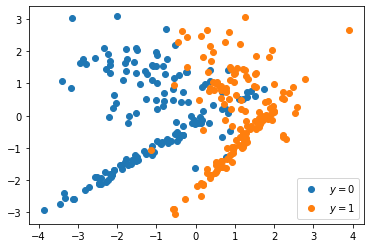

In [4]:
def show_classes(X, y):
    plt.figure()
    plt.scatter(X[y==0][:,0], X[y==0][:,1], label='$y=0$')
    plt.scatter(X[y==1][:,0], X[y==1][:,1], label='$y=1$')
    plt.legend()
    plt.show()


show_classes(X, y)

# Logistic Regression

We have a classification problem where we want to say what is the probability of some binary event $y$ happening given some information we have $x$ where $x \in \mathbb{R}^d$.  To do this, we can find some 

$$
P(y|x) \sim Bernoulli(\sigma(w^TX))
$$

Our binary outcome is $y=0$ or $y=1$. Our feature vector is $x$. Our set of observations is $X$ and labels is $y$. We assume $y$ is i.i.d.


$$
\sigma(a) = \frac{1}{1 + e^{-a}}
$$

In [5]:
def sigmoid(a):
    return 1 / (1 + jnp.exp(-a))

# Loss definition

Given our framework for modeling, we need to determine a cost or loss function. Given some weights $w$ and observed features $X = \{x_1,\dots, x_n\}$ and values $y = \{y_1, \dots, y_n\}$

$$
l(w,X,y) = \texttt{probability of events observed given our expectation of them happening}
$$

$$
L(w,X,y) = \prod_{i=1}^n y_i \cdot \sigma(w^Tx) + (1 - y_i) \cdot (1 - \sigma(w^Tx))
$$

We want to maximize this loss function (MLE) over the parameter space $w$ given $X$ and $y$ are fixed. In practive we end up minimizing the -log because it's a little easeier.

$$
\textit{argmin}_w  \sum_{i=1}^n - \log (y_i \cdot \sigma(w^Tx)) + (1 - y_i) \cdot (1 - \sigma(w^Tx)))
$$

It may be easier to work with the Bernoulli distribution in the form $p^y(1-p)^{1-y}$ over $yp + (1-y)(1-p)$ because as we take the log of everything, the exponential form simplifies to multiplication.

$$
\textit{argmin}_w \sum_{i=1}^n - \log \big( \sigma(w^Tx_i)^{y_i}(1-\sigma(w^Tx_i)^{1-y_i})\big)
$$

$$
\textit{argmin}_w \sum_{i=1}^n - y_i \log \big( \sigma(w^Tx_i)\big) - (1-y_i) \log \big((1-\sigma(w^Tx_i))\big)
$$

We cannot solve for this outright but we can analytically approximate it. To do so, we take the gradient + some optimization method (often Newtons method), 

In [6]:
# example of how the model predicts classes
w = jnp.array([-4., 2.])
y_hat = (sigmoid(jnp.matmul(w, X.T)) > 0.5).astype(int)
show_classes(X, y_hat)

In [7]:
X = jnp.array(X)
y = jnp.array(y)

Newtons method

$$
x_{n+1} = x_{n} - \frac{f(x_n)}{f'(x_n)}
$$

In [30]:
jnp.max

<function jax._src.numpy.lax_numpy.amax(a, axis: Union[int, Tuple[int, ...], NoneType] = None, out=None, keepdims=None, initial=None, where=None)>

In [72]:
def loss_a(w, X, y):
    sig = sigmoid(jnp.matmul(w, X.T))
    sig = jnp.where(sig > 1e-8, sig, 1e-8)  # make sure we don't get NaNs w/ log(0)
    sig = jnp.where(sig > (1 - 1e-6), 1 - 1e-6, sig)  # make sure we don't get NaNs w/ log(0)
    log_likelihood = jnp.where(y, jnp.log(sig), jnp.log(1 - sig))
    return -jnp.sum(log_likelihood)

loss_grad = grad(loss_a)

@jit
def optimize(X, y):
    w = jnp.array([1.0, 1.0])

    def minimize(w, x):
        step = 0.001
        delta = loss_grad(w, X, y) * step
        loss = loss_a(w, X, y)
        return w - delta, loss

    return lax.scan(minimize, w, None, length=1000)

@jit
def newton(X, y):
    w = jnp.array([1.0, 1.0])

    def minimize(w, x):
        f = loss_grad
        df = jacrev(f)
        delta = f(w, X, y) / df(w, X, y)


        loss = loss_a(w, X, y)
        return w - delta, loss

    return lax.scan(minimize, w, None, length=1000)


class LogReg():
    def __init__(self):
        self.coefs_ = None
        
    def fit(self, X, y):
        self.coefs_, self.losses = newton(X, y)
        
    def predict_proba(self, X):
        if self.coefs_ is None:
            raise 'Need to fit model'
            
        return sigmoid(jnp.matmul(self.coefs_, X.T))
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return float((y_hat == y).mean())
        
            
        
        

In [137]:
w = jnp.array([2., 3.])
f = loss_grad
j = jacrev(f)
print('current loss', loss_a(w, X, y))

current loss 343.56543


In [138]:
j(w, X, y)

DeviceArray([[ 35.437588, -21.52419 ],
             [-21.524189,  19.54453 ]], dtype=float32)

In [134]:
delta = jnp.matmul(jnp.linalg.inv(j(w, X, y)), f(w, X, y))
w = w - delta
print('current loss', loss_a(w, X, y))

current loss 2170.965


In [132]:
w

DeviceArray([ -5.3055105, -11.77103  ], dtype=float32)

In [83]:
np.matmul([[1, 0], [0, 1]])

TypeError: matmul() takes from 2 to 3 positional arguments but 1 were given

In [88]:
jnp.matmul(np.eye(3) * 2, jnp.array([3,2,1]))

DeviceArray([6., 4., 2.], dtype=float32)

In [92]:
H

DeviceArray([[[ 5.934048 ,  4.4623914],
              [ 4.462379 ,  2.9546475]],

             [[ 4.4623556,  2.9546323],
              [ 2.954606 , -5.7235107]]], dtype=float32)

In [81]:
jnp.matmul(jnp.linalg.inv(H), loss_grad(w, X, y))

DeviceArray([[ 409.82495 , -613.91956 ],
             [ -50.09481 ,  -28.459578]], dtype=float32)

In [134]:
%%time
print('JAX MODEL')
m = LogReg()
m.fit(X, y)
y_hat = m.predict(X)
m.score(X, y)

JAX MODEL


TypeError: Gradient only defined for scalar-output functions. Output had shape: (2,).

In [173]:
a = np.array([1, 2])

In [127]:
%%time
print('SKLEARN MODEL')
m = LogisticRegression()
m.fit(X, y)
m.score(X, y)

SKLEARN MODEL
CPU times: user 4.51 ms, sys: 1.71 ms, total: 6.21 ms
Wall time: 4.69 ms


0.86

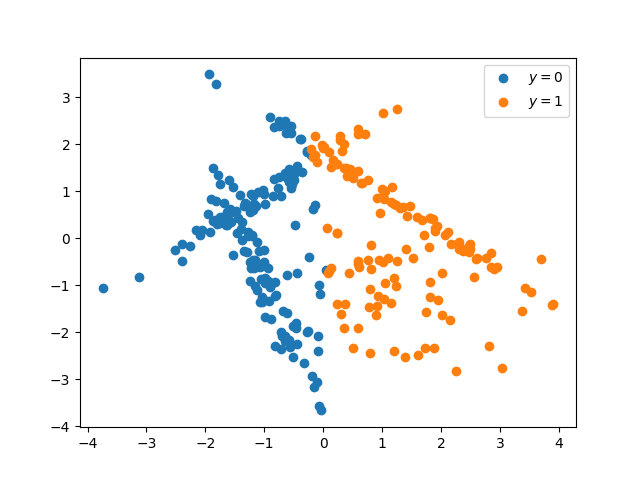

In [129]:
show_classes(X, y_hat)

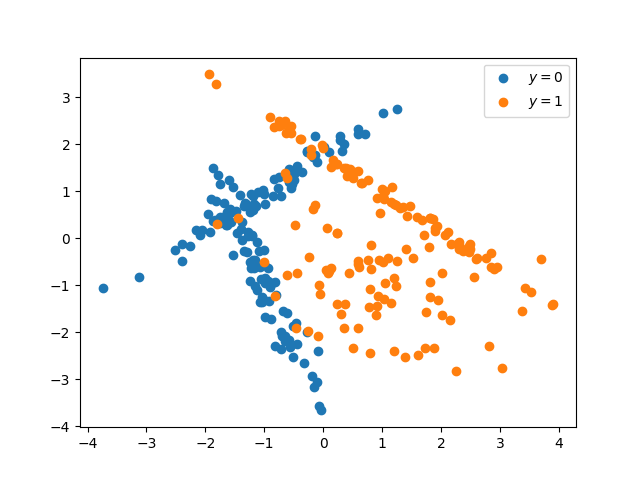

In [130]:
show_classes(X, y)